In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from pyshred import DataManager, SHRED, SHREDEngine, MLP, PI_SHRED, LSTM, LSTM_PI, PI_SHRED_V2, MLP_TRUNK
from torch.utils.data import DataLoader, random_split
import Master_utilz as utilz
from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.integrate import solve_ivp
from torch.autograd import grad

plt.rcParams.update({
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm",       # Computer Modern for math
    "axes.unicode_minus": False,    # So minus sign appears correctly
})


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

4.8e-05
106348
Finished RK4 with 106348 iterations final time = 5.104704


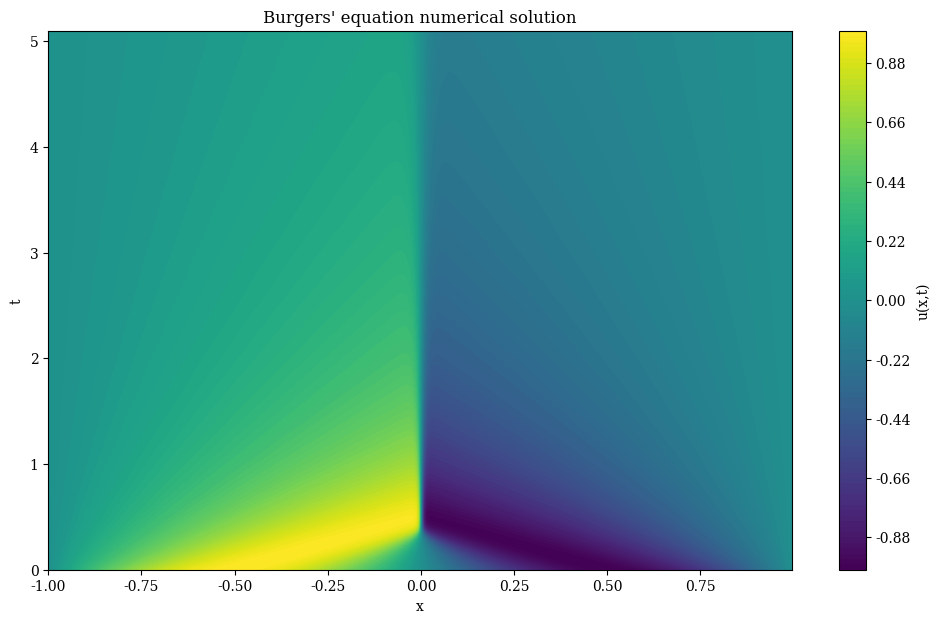

In [4]:
#Creating data by solving the burgers equation in 1D
def init_KS(x,t=0):
    u = (1+np.sin(x/10))
    return u

def Fourier_n(u, Omega,n):
    u_hat = (1j*Omega)**n*fft(u)
    u_hat = ifft(u_hat)
    return u_hat

N = 500
L = 2
x = np.linspace(-L/2, L/2, N, endpoint=False)
nu = 0.01/np.pi
n = fftfreq(N)*N
scale = 2*np.pi/L
Omega = scale*n
u0 = -np.sin(np.pi*x)

def burgers(u, Omega,nu):
    dudt = -0.5*Fourier_n(u*u, Omega, 1)+nu*Fourier_n(u, Omega, 2)
    return np.real(dudt)

def runge_kutta(u0,dudt,dt,iters, Omega,nu):
    t_all = np.zeros(iters)
    u_sol_all = np.zeros((iters,u0.size))
    u_sol = u0.copy()
    for i in range(iters):
        k1 = dudt(u_sol,Omega,nu)
        k2 = dudt(u_sol + 0.5*dt*k1,Omega,nu)
        k3 = dudt(u_sol + 0.5*dt*k2,Omega,nu)
        k4 = dudt(u_sol + dt*k3,Omega,nu)
        u_sol = u_sol + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        u_sol_all[i,:] = u_sol
        t_all[i] = dt*i
    print(f"Finished RK4 with {iters} iterations final time = {dt*iters}")
    return u_sol_all,t_all

delta_t = 2*np.abs(6 / ((N) ** 2))
print(delta_t)
t_end =  1.6037/np.pi*10

iters = int(t_end/delta_t)
print(iters)
img_test = max(u0)*2/N
u_sol,t = runge_kutta(u0,burgers,delta_t,iters, Omega,nu)

t_skips = iters//200
# t_skips = 210
x_skips = 1
t = t[::t_skips]
u_sol = u_sol[::t_skips,::x_skips]
x = x[::x_skips]
delta_t_synth = delta_t*t_skips

fig,ax = plt.subplots(figsize=(12,7))   
ax.contourf(x,t,u_sol, 100, cmap="viridis")
ax.set_title("Burgers' equation numerical solution (solve_ivp)")
ax.set_title("Burgers' equation numerical solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.colorbar(ax.collections[0], ax=ax, label='u(x,t)')
plt.show()

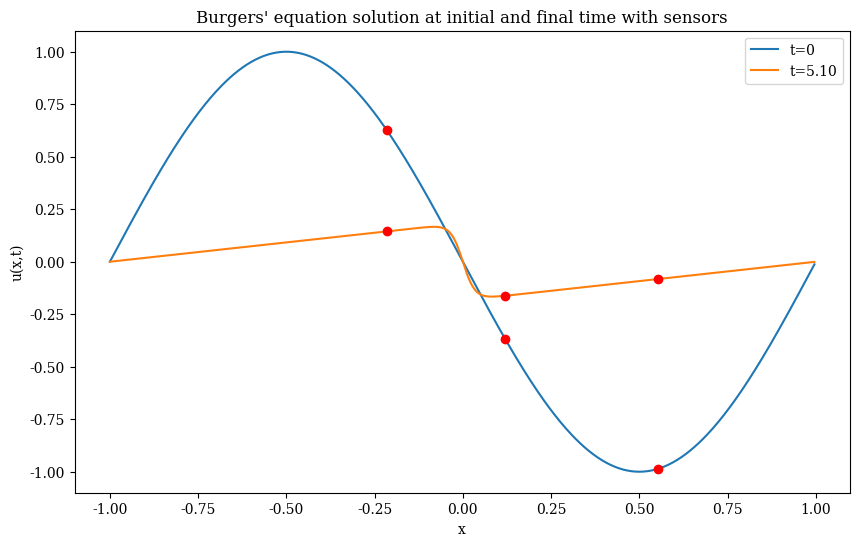

In [5]:
lags = 10
nr_sensors = 3
np.random.seed(41)
sensors  = np.random.choice(np.arange(0,u_sol.shape[1]),nr_sensors,replace = False)
# test_frames = 5
X_train,y_train = utilz.trajectory_gen([u_sol],lags =lags, sensors=sensors)
# X_train,y_train,_ = utilz.data_prepare([u_sol],lags =lags, sensors=sensors)

training_skips = 1
X_train = X_train
y_train = y_train[:,::training_skips]
# x = x[::training_skips]

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(x,u_sol[0,:], label='t=0')
for sensor in sensors:
    ax.plot(x[sensor], u_sol[0,sensor],"o", color='red')
ax.plot(x,u_sol[-1,:], label=f't={t[-1]:.2f}')
for sensor in sensors:
    ax.plot(x[sensor], u_sol[-1,sensor],"o", color='red')
ax.set_title("Burgers' equation solution at initial and final time with sensors")
ax.set_xlabel("x")
ax.set_ylabel("u(x,t)")
ax.legend()
plt.show()

In [6]:
model_dtype = torch.float32

Burger_data = {
    'X':X_train,
    "coords" : x[::training_skips,None],
    'y':y_train,
}

batch_size = 32


Burger_dataset = utilz.SHREDdata_PI(Burger_data)
train_dataset, val_dataset, _ = Burger_dataset.split_data(train_ratio = 0.6,val_ratio=0.4, test_ratio=0.0 , sequential_split=True)

train_dataset.move_to_device(device, model_dtype=model_dtype)
val_dataset.move_to_device(device, model_dtype=model_dtype)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)



for X,coords, y in train_loader:
    print("X.shape", X.shape)
    print("Coords.shape",coords.shape)
    print("y.shape", y.shape)
    # print(shred.forward(X,coords[0])[0].shape)
    break


X.shape torch.Size([32, 10, 3])
Coords.shape torch.Size([32, 500, 1])
y.shape torch.Size([32, 500])


In [7]:
torch.set_default_dtype(model_dtype)
sequence_model = LSTM_PI(hidden_size=32, num_layers=2)
trunk_model = MLP_TRUNK(hidden_sizes=[64,128], dropout=0.1)


jakob_shred = PI_SHRED_V2(sequence_model=sequence_model,
    trunk_model=trunk_model)

jakob_shred.sequence_model.initialize(input_size=X_train.shape[2], lags=lags, decoder_type="MLP_PI",dtype = model_dtype)
jakob_shred.trunk_model.initialize(input_size=1, output_size=jakob_shred.sequence_model.hidden_size)
jakob_shred.to(device, dtype=model_dtype)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(jakob_shred.parameters(), lr=0.001)

jakob_shred.train()
training_skips = 1
# def get_dx(model, coords):
#     return model.forward()
for epoch in range(2000):    
    epoch_loss = 0.0
    for X,coords, y in train_loader:
        coords = coords[0][::training_skips,:]  
        # coords = coords[0][240:250,:]  
        # print(y.shape)
        y = y[:,::training_skips]
        # y = y[:,240:250]
        
        # print(y.shape)
        # print(coords.shape)
        # coords.requires_grad_(True)
        optimizer.zero_grad()
        output_t, output_tm1,output_tm2 = jakob_shred.forward(X, coords)
        data_loss = criterion(output_t, y)
        loss = data_loss

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    if (epoch % 100) == 0:
        print(f"at epoch {epoch} the data loss is {torch.sum(data_loss):.7f}")
        # print(coords)
        # print(y)
    # break

Yay LSTM_PI has been initialized
yaaay we are initializing MLP_PI
at epoch 0 the data loss is 0.0846880
at epoch 100 the data loss is 0.0026214
at epoch 200 the data loss is 0.0018427
at epoch 300 the data loss is 0.0013232
at epoch 400 the data loss is 0.0009550
at epoch 500 the data loss is 0.0011115
at epoch 600 the data loss is 0.0008565
at epoch 700 the data loss is 0.0011340
at epoch 800 the data loss is 0.0006829
at epoch 900 the data loss is 0.0005523
at epoch 1000 the data loss is 0.0005412
at epoch 1100 the data loss is 0.0005688
at epoch 1200 the data loss is 0.0006409
at epoch 1300 the data loss is 0.0005868
at epoch 1400 the data loss is 0.0004528
at epoch 1500 the data loss is 0.0004487
at epoch 1600 the data loss is 0.0004130
at epoch 1700 the data loss is 0.0004659
at epoch 1800 the data loss is 0.0004513
at epoch 1900 the data loss is 0.0004282


In [8]:
sequence_model = LSTM(hidden_size=32, num_layers=2)
decoder_model = MLP(hidden_sizes=[350,400], dropout=0.1)


SD_shred = PI_SHRED(sequence_model=sequence_model,
    decoder_model=decoder_model)

SD_shred.sequence.initialize(input_size=X_train.shape[2], lags=lags, decoder_type="MLP",dtype = model_dtype)
SD_shred.decoder.initialize(input_size=SD_shred.sequence.hidden_size, output_size=y_train.shape[1])
SD_shred.to(device, dtype=model_dtype)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(SD_shred.parameters(), lr=0.001)

SD_shred.train()
# def get_dx(model, coords):
#     return model.forward()
for epoch in range(1000):    
    epoch_loss = 0.0
    for X,coords, y in train_loader:
        coords = coords[0]  
        # coords.requires_grad_(True)
        optimizer.zero_grad()
        output_t = SD_shred.forward(X, coords)
        data_loss = criterion(output_t, y)
        loss = data_loss

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    if (epoch % 100) == 0:
        print(f"at epoch {epoch} the data loss is {torch.sum(data_loss):.7f}")
    #     break
    # break

Booo LSTM has been initialized
at epoch 0 the data loss is 0.3505076
at epoch 100 the data loss is 0.0029318
at epoch 200 the data loss is 0.0006684
at epoch 300 the data loss is 0.0002924
at epoch 400 the data loss is 0.0001440
at epoch 500 the data loss is 0.0002388
at epoch 600 the data loss is 0.0001072
at epoch 700 the data loss is 0.0000903
at epoch 800 the data loss is 0.0000796
at epoch 900 the data loss is 0.0003235


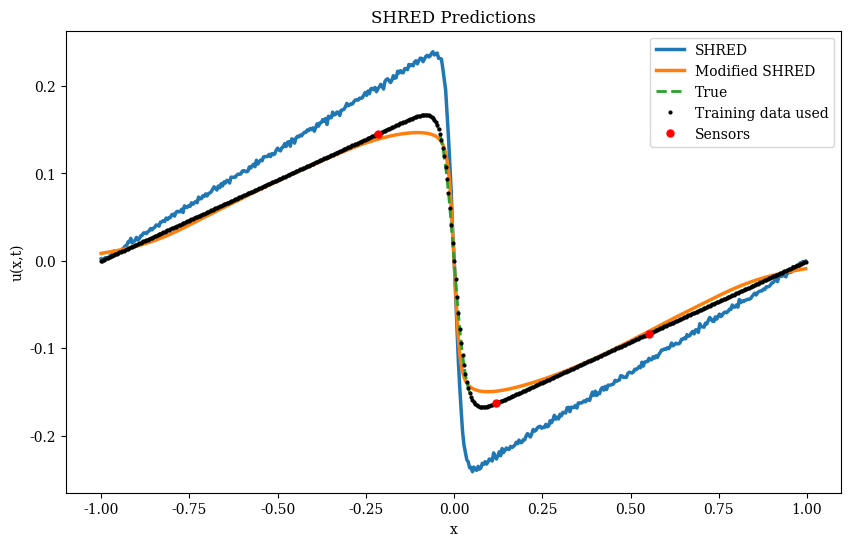

In [9]:
# visualize_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

visualize_loader = val_loader
index = int(1*len(visualize_loader)-1)
# index = 0
counter = 0
jakob_shred.eval()
SD_shred.eval()
for X, coords, y in visualize_loader:
    if counter == index:
        coords = coords[0]
        output_t_jakob, _, _ = jakob_shred.forward(X, coords)
        output_t_SD = SD_shred.forward(X)
        plt.figure(figsize=(10,6))
        plt.plot(coords.cpu().numpy(), output_t_SD[0].detach().cpu().numpy(), label='SHRED', linewidth=2.5)
        plt.plot(coords.cpu().numpy(), output_t_jakob[0].detach().cpu().numpy(), label='Modified SHRED', linewidth=2.5)
        plt.plot(coords.cpu().numpy(), y[0].cpu().numpy(), '--', label='True', linewidth=2)
        plt.plot(coords[::training_skips,:] .cpu().numpy(), y[0,::training_skips].cpu().numpy(), 'o', color = "black",label='Training data used', markersize=2)
        # plt.plot(coords[240:250,:] .cpu().numpy(), y[0,240:250].cpu().numpy(), 'o', color = "black",label='Training data used', markersize=2)
        plt.title('SHRED Predictions')
        plt.xlabel('x')
        plt.ylabel('u(x,t)')
        first_sensor = True
        for sensor in sensors:
            if first_sensor:
                plt.plot(coords[sensor].cpu().numpy(), y[0,sensor].cpu().numpy(),"o", color='red', label='Sensors',markersize=5)
                first_sensor = False
            else:
                plt.plot(coords[sensor].cpu().numpy(), y[0,sensor].cpu().numpy(),"o", color='red', markersize=5)
        plt.legend()
        plt.show()
        break   
    counter+= 1
    

In [10]:
print(X.device)

cuda:0


In [15]:
from io import BytesIO
from PIL import Image
images = []
visualize_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

jakob_shred.eval()
SD_shred.eval()
for i, (X, coords, y) in enumerate(visualize_loader):
    print(f"starting loop {i}")
    coords = coords[0]
    output_t_jakob, _, _ = jakob_shred.forward(X, coords)
    output_t_SD = SD_shred.forward(X)
    plt.figure(figsize=(10,6))
    plt.plot(coords.cpu().numpy(), output_t_SD[0].detach().cpu().numpy(), label='SHRED', linewidth=2.5)
    plt.plot(coords.cpu().numpy(), output_t_jakob[0].detach().cpu().numpy(), label='Modified SHRED', linewidth=2.5)
    plt.plot(coords.cpu().numpy(), y[0].cpu().numpy(), '--', label='True', linewidth=2)
    plt.plot(coords[::training_skips,:] .cpu().numpy(), y[0,::training_skips].cpu().numpy(), 'o', color = "black",label='Training data used', markersize=2)
    # plt.plot(coords[240:250,:] .cpu().numpy(), y[0,240:250].cpu().numpy(), 'o', color = "black",label='Training data used', markersize=2)
    plt.title(f'SHRED Predictions with {nr_sensors} sensors at time step {t[i]:.4f}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    first_sensor = True
    for sensor in sensors:
        if first_sensor:
            plt.plot(coords[sensor].cpu().numpy(), y[0,sensor].cpu().numpy(),"o", color='red', label='Sensors',markersize=5)
            first_sensor = False
        else:
            plt.plot(coords[sensor].cpu().numpy(), y[0,sensor].cpu().numpy(),"o", color='red', markersize=5)
    plt.legend()
    plt.grid()
    plt.xlim([-L/2, L/2])
    plt.ylim([-1.2, 1.2])
    buf = BytesIO()
    plt.savefig(buf, format = 'png')
    buf.seek(0)
    images.append(Image.open(buf))
    plt.close()
    plt.show()

    

starting loop 0
starting loop 1
starting loop 2
starting loop 3
starting loop 4
starting loop 5
starting loop 6
starting loop 7
starting loop 8
starting loop 9
starting loop 10
starting loop 11
starting loop 12
starting loop 13
starting loop 14
starting loop 15
starting loop 16
starting loop 17
starting loop 18
starting loop 19
starting loop 20
starting loop 21
starting loop 22
starting loop 23
starting loop 24
starting loop 25
starting loop 26
starting loop 27
starting loop 28
starting loop 29
starting loop 30
starting loop 31
starting loop 32
starting loop 33
starting loop 34
starting loop 35
starting loop 36
starting loop 37
starting loop 38
starting loop 39
starting loop 40
starting loop 41
starting loop 42
starting loop 43
starting loop 44
starting loop 45
starting loop 46
starting loop 47
starting loop 48
starting loop 49
starting loop 50
starting loop 51
starting loop 52
starting loop 53
starting loop 54
starting loop 55
starting loop 56
starting loop 57
starting loop 58
startin

In [ ]:
save_path = "Burgers_viz/" + f"val_v4_recon_{nr_sensors}_sensors.gif"

images[0].save(save_path,
            save_all=True,
            append_images=images[1:],
            duration=200,
            loop=0)

In [ ]:
# plotting the input X
fig,ax = plt.subplots(figsize=(6,4))
for i in range(X_train.shape[2]):
    ax.plot(X_train[-1,:,i], label=f'Sensor {i+1}')
ax.set_title("Input sensor data over time")
ax.set_xlabel("Time step")
ax.set_ylabel("Sensor readings")
ax.legend()
plt.show()